# 1.2 Marginal Gaussianization

In [1]:
#@title Install Packages
# %%capture
try:
    import sys, os
    from pyprojroot import here

    # spyder up to find the root
    root = here(project_files=[".here"])

    # append to path
    sys.path.append(str(here()))
except ModuleNotFoundError:
    %%capture
    import os
    os.system("pip install objax chex")
    os.system("pip install git+https://github.com/IPL-UV/rbig_jax.git#egg=rbig_jax")

In [2]:
# jax packages
import jax
import jax.numpy as np
from jax.config import config
import chex
config.update("jax_enable_x64", False)

import numpy as onp
from functools import partial

# library parameters
from rbig_jax.data import get_classic
from rbig_jax.plots import plot_info_loss, plot_joint, plot_joint_prob

# logging
import tqdm
import wandb

# plot methods
import matplotlib.pyplot as plt
import seaborn as sns
sns.reset_defaults()
sns.set_context(context="talk", font_scale=0.7)

%matplotlib inline
%load_ext autoreload
%autoreload 2

## Data

<Figure size 432x288 with 0 Axes>

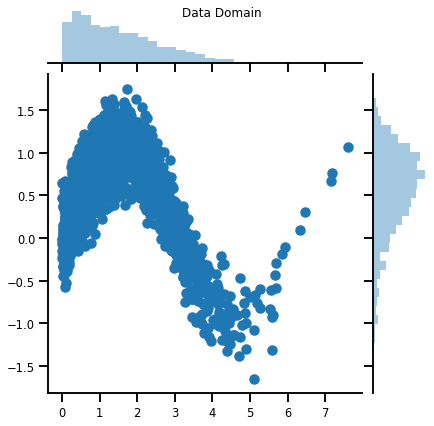

In [3]:
# %%wandb
# get data
n_samples = 2_000
n_features = 2
data = get_classic(n_samples)

# plot data
plt.figure()
sns.jointplot(data[:, 0], data[:, 1])
plt.suptitle('Data Domain')
plt.show()

In [4]:
X = np.array(data, dtype=np.float32)

/home/emmanuel/.conda/envs/jax_py38/lib/python3.8/site-packages/jax/lib/xla_bridge.py:130: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


## Initialization

First we need to initialize our RBIG method with some parameters. For example, which marginal gaussianization method, what precision do we want, and what rotation method do we want.

* `method` - the method used to marginally transform the data. We have histogram or kde currently implemented
* `support_extension` - this is the amount we want to extend the support for our marginal distributions. Higher values indicate higher
* `precision` - we use interpolation because it is much faster. So the CDF, PDF and PPF are interpolation schemes. This value will allow one to have more "precision" for the estimated quantities but it will be slower.

In [5]:
from rbig_jax.transforms.histogram import InitUniHistUniformize
from rbig_jax.transforms.kde import InitKDEUniformize

support_extension = 10
alpha = 1e-5
precision = 100
nbins = int(np.sqrt(X.shape[0]))

# initialize histogram transformation
fit_transform_f, forward_f, grad_f, inverse_f = InitUniHistUniformize(
    n_samples=X.shape[0],
    nbins=nbins,
    support_extension=support_extension,
    precision=precision,
    alpha=alpha
)

In [6]:
from rbig_jax.transforms.marginal import (
    marginal_fit_transform, 
    marginal_transform, 
    marginal_gradient_transform
)

#### Forward Fit Transform

In [7]:
X_u, params = marginal_fit_transform(X, fit_transform_f)

chex.assert_equal_shape([X_u, X])
chex.assert_equal(params.empirical_pdf.shape[0], X.shape[1])

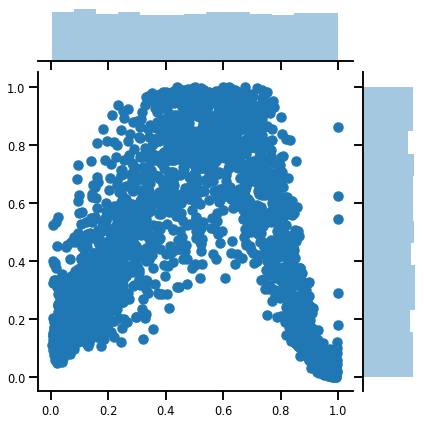

In [8]:
sns.jointplot(X_u[:, 0], X_u[:, 1])

#### Forward Transform

In [9]:
X_u = marginal_transform(X, params, forward_f)

chex.assert_equal_shape([X_u, X])

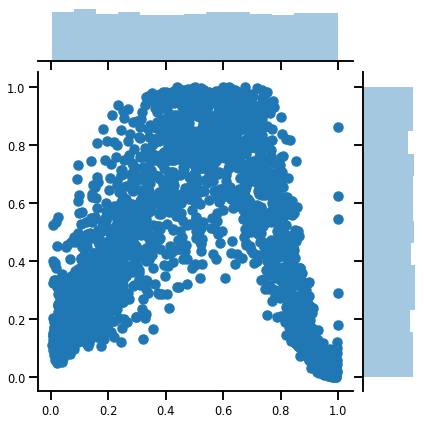

In [10]:
sns.jointplot(X_u[:, 0], X_u[:, 1])

#### Inverse Transformation

In [11]:
X_approx = marginal_transform(X_u, params, inverse_f)

chex.assert_equal_shape([X_approx, X])

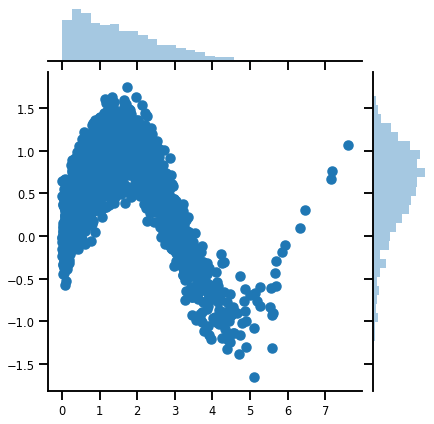

In [12]:
sns.jointplot(X_approx[:, 0], X_approx[:, 1])

### Gradient Transform

In [13]:
X_u_, X_ldj_u = marginal_gradient_transform(X, params, grad_f)

chex.assert_equal_shape([X_u, X])
chex.assert_tree_all_close(X_u_, X_u)
chex.assert_equal_shape([X_ldj_u, X])

### Log Probability

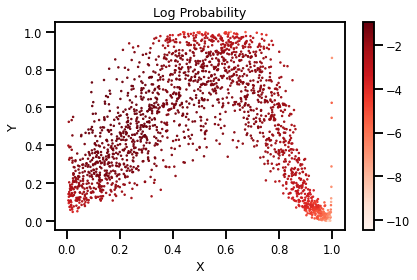

In [14]:
cmap = "Reds"
log_prob = X_ldj_u.sum(axis=1)
# probs = np.clip(probs, 0.0, 1.0)
log_prob = np.clip(log_prob, None, 0.0)
title = "Log Probability"

fig, ax = plt.subplots()
h = ax.scatter(X_u[:, 0], X_u[:, 1], s=1, c=log_prob,  cmap=cmap)
plt.xlabel("X")
plt.ylabel("Y")
plt.colorbar(h)
ax.set_title(title)
plt.tight_layout()

#### Probability

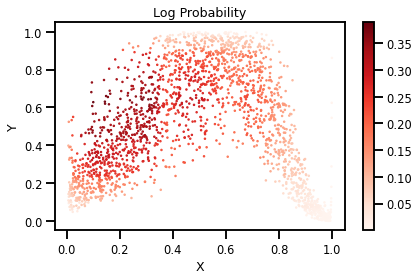

In [15]:
cmap = "Reds"
prob = np.exp(log_prob)
# probs = np.clip(probs, 0.0, 1.0)
prob = np.clip(prob, 0.0, 1.0)
title = "Log Probability"

fig, ax = plt.subplots()
h = ax.scatter(X_u[:, 0], X_u[:, 1], s=1, c=prob,  cmap=cmap)
plt.xlabel("X")
plt.ylabel("Y")
plt.colorbar(h)
ax.set_title(title)
plt.tight_layout()

## Inverse CDF Transformation

In [16]:
from rbig_jax.transforms.inversecdf import InitInverseGaussCDF

# univariate normalization Gaussianization parameters
eps = 1e-5

# initialize histogram transformation
fit_transform_f, forward_f, grad_f, inverse_f = InitInverseGaussCDF(eps=eps)

In [17]:
X_g, params = marginal_fit_transform(X_u, fit_transform_f)

chex.assert_equal_shape([X_g, X])

/home/emmanuel/.conda/envs/jax_py38/lib/python3.8/site-packages/jax/lax/lax.py:6190: UserWarning: Explicitly requested dtype float64 requested in array is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  warnings.warn(msg.format(dtype, fun_name , truncated_dtype))


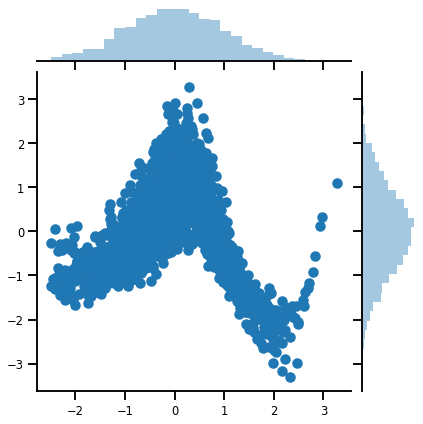

In [18]:
sns.jointplot(X_g[:, 0], X_g[:, 1])

### Forward Transformation

In [19]:
X_g_ = marginal_transform(X_u, params, forward_f)

chex.assert_tree_all_close(X_g_, X_g)

### Inverse Transformation

In [20]:
X_u_approx = marginal_transform(X_g, params, inverse_f)

chex.assert_tree_all_close(X_u, X_u_approx)

AssertionError: 
Not equal to tolerance rtol=1e-07, atol=0
Error in value equality check: Values not approximately equal
Mismatched elements: 876 / 4000 (21.9%)
Max absolute difference: 1.1920929e-07
Max relative difference: 1.2295973e-06
 x: array([[0.729594, 0.334866],
       [0.684924, 0.50063 ],
       [0.229881, 0.662854],...
 y: array([[0.729594, 0.334866],
       [0.684924, 0.50063 ],
       [0.229881, 0.662854],...

### Gradient Transform

In [ ]:
X_g_, X_ldj_g = marginal_gradient_transform(X_u, params, grad_f)

chex.assert_tree_all_close(X_g, X_g_)
chex.assert_equal_shape([X_ldj_g, X])

#### Probabilities

In [ ]:
latent_prob = jax.scipy.stats.norm.logpdf(X_g)

log_prob = latent_prob.sum(axis=1) + X_ldj_g.sum(axis=1) + X_ldj_u.sum(axis=1)

In [ ]:
cmap = "Reds"
probs = log_prob
# probs = np.clip(probs, 0.0, 1.0)
probs = np.clip(probs, None, 0.0)
title = "Log Probability"

fig, ax = plt.subplots()
h = ax.scatter(X[:, 0], X[:, 1], s=1, c=probs,  cmap=cmap)
plt.xlabel("X")
plt.ylabel("Y")
plt.colorbar(h)
ax.set_title(title)
plt.tight_layout()

In [ ]:
cmap = "Reds"
probs = np.exp(log_prob)
probs = np.clip(probs, 0.0, 1.0)
title = "Probability"

fig, ax = plt.subplots()
h = ax.scatter(data[:, 0], data[:, 1], s=1, c=probs,  cmap=cmap)
plt.xlabel("X")
plt.ylabel("Y")
plt.colorbar(h)
ax.set_title(title)
plt.tight_layout()